In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 30

In [3]:
# load the data call (dir, shuffle, imgsize. batchsize)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "Plant Village",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
# check the class names (folder names)
class_names = dataset.class_names

In [5]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
# we have a batch size of 32
len(dataset)

501

In [7]:
32*501

16032

In [8]:
# Check for the shape of the batch convert label batch to numpy as its in tensor dataset
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[4 9 3 7 7 6 0 9 9 2 6 7 3 2 7 9 9 0 1 0 0 1 0 0 6 5 7 0 7 7 6 9]


In [9]:
# print the firstimage every numnber is between 0, 255
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[124., 118., 120.],
        [127., 121., 123.],
        [122., 116., 118.],
        ...,
        [ 99.,  91.,  89.],
        [102.,  94.,  92.],
        [105.,  97.,  95.]],

       [[122., 116., 118.],
        [124., 118., 120.],
        [119., 113., 115.],
        ...,
        [102.,  94.,  92.],
        [104.,  96.,  94.],
        [105.,  97.,  95.]],

       [[125., 119., 121.],
        [126., 120., 122.],
        [123., 117., 119.],
        ...,
        [104.,  96.,  94.],
        [105.,  97.,  95.],
        [105.,  97.,  95.]],

       ...,

       [[138., 131., 125.],
        [139., 132., 126.],
        [132., 125., 119.],
        ...,
        [ 99.,  90.,  85.],
        [101.,  92.,  87.],
        [102.,  93.,  88.]],

       [[119., 112., 106.],
        [123., 116., 110.],
        [119., 112., 106.],
        ...,
        [ 98.,  89.,  84.],
        [ 98.,  89.,  84.],
       

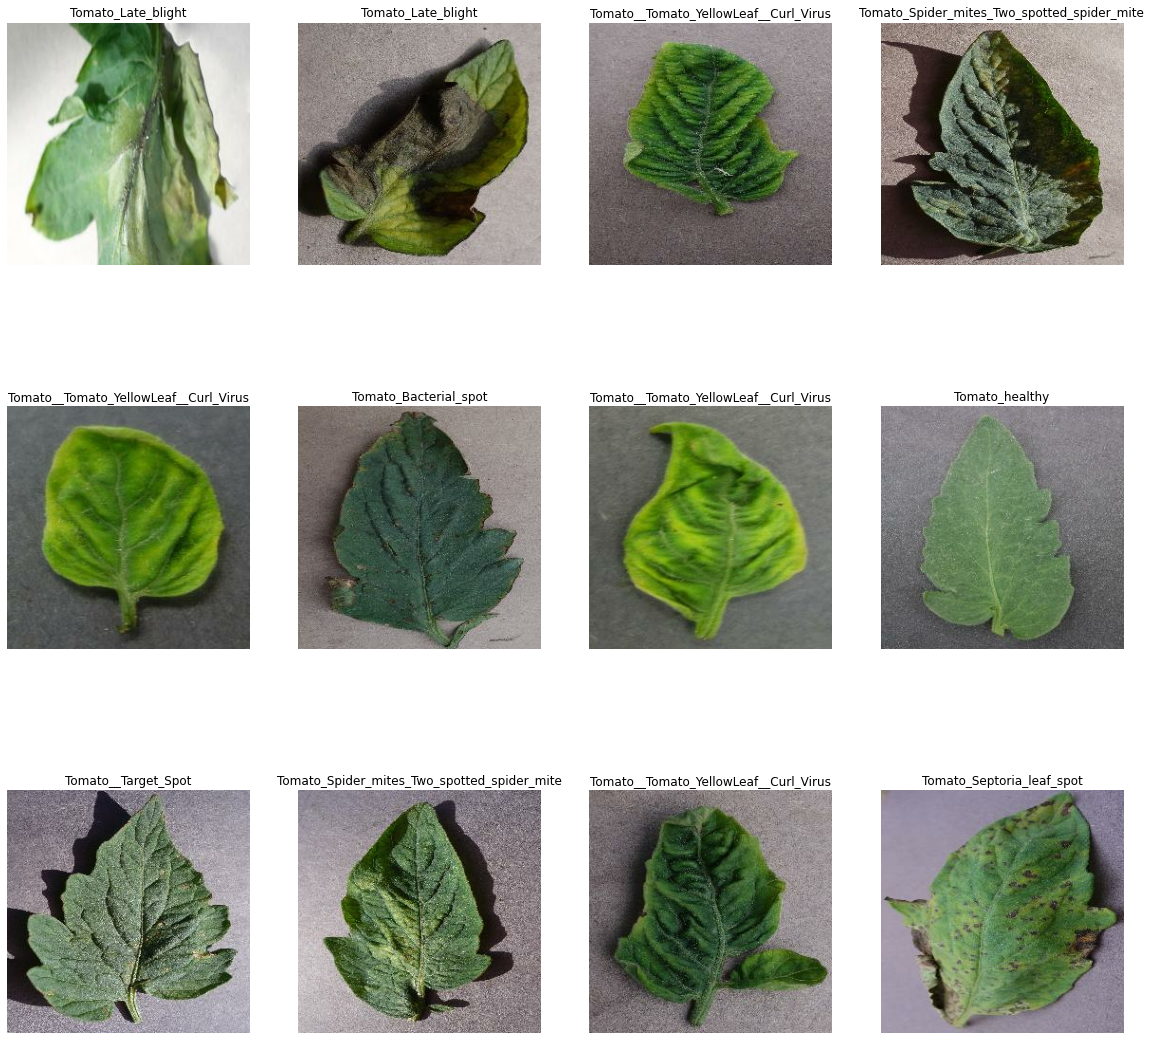

In [10]:
# visualize this image range_value should be equal to the subplot size 
range_value = 12
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        # to show the batch create a subplot
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # remove the axis
        plt.axis("off")
        # display the title
        plt.title(class_names[label_batch[i]])

In [11]:
# 80% ==> training
# 10% ==> validation
# 10% ==> test
# sample space = 16032
# 501 * 0.8 = 400.8 batch is train dataset
training_size = 0.8
train_ds = dataset.take(400)

In [12]:
# slice the first 400 to get the remaning ds
test_ds = dataset.skip(400)

In [13]:
# 501 * 0.1 = 50.1 batches 
val_size = 0.1
val_ds = test_ds.take(50)
len(val_ds)

50

In [14]:
act_test_ds = test_ds.skip(50)

In [15]:
# Get ds methods
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    # get sizes
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    test_size = int(ds_size*test_split)

    # get ds
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

400

In [18]:
len(val_ds)

50

In [19]:
len(test_ds)

50

In [20]:
# cache to have pre-memory to improve performance
# prefetch is used for parallel (GPU and CPU training cycle)
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
# preprocessing pipeline
# scale the image
# resizing
# make the maodel robust by normalizing the image using data augmentation
# data augmentation is used to create new samples by rotation, horizontal and vertical flip, contrast, zoom
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
# data augmentation is used to create new samples by rotation, horizontal and vertical flip, contrast, zoom
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
# build layers
# filters and kernal size
# Conv2D (filterbatch, (filtersize-x, filtersize-y), activation layer, Imagesize) 
# pooling layers 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
# compile the model using adam optimizer

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
# Training using EPOCHS = 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 1.2120 - accuracy: 0.5725